This does not work in the VSCode environment as-is.  The animation is not visible at all.

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import numpy as np
from numpy.linalg import solve as linsolve


# Transmission Line Definition

In [2]:
c = 3.e10/np.sqrt(4) # cm/s
Zs = 75
Zo = 50
Zl = 75
Cload = 1e-12

K = 101 # Spatial Points
N = 2001

l = 5. # 5 cm (line length)

# Pulse

<IPython.core.display.Javascript object>


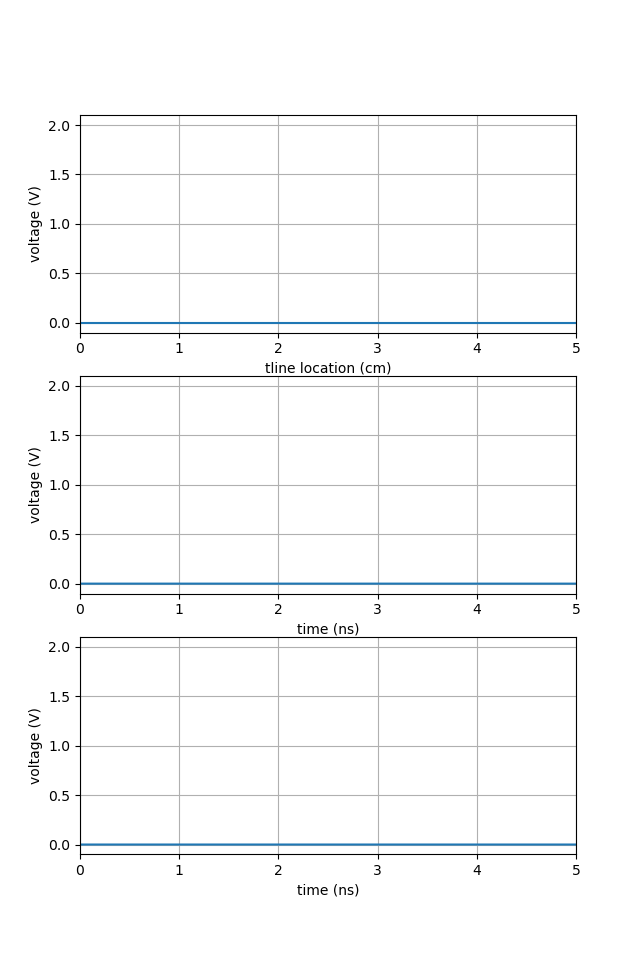

Av condition =  75.67682627644892
[[0.01       0.00333333 0.        ]
 [0.         0.02666667 0.        ]
 [0.         0.         0.02666667]]


In [3]:

t, dt = np.linspace(0., 5e-9, N, retstep=True)
x, dz = np.linspace(0., l, K, retstep=True)

# Define the source voltage.
def unitstep(t, t0):
    return (t >= t0) * 1.0

def unitramp(t, t0):
    return unitstep(t,t0) * (t-t0)

tstart = 25e-12 
tstop = 10000e-12 
tramp = 25e-12 
vs = (unitramp(t, tstart) - unitramp(t,tstart+tramp) - unitramp(t,tstop) + unitramp(t,tstop+tramp))/tramp

# Initialize the matrices.
Av = np.zeros((K+2,K+2)) # x vv next
Bv = np.zeros((K+2,K+2)) # x vv previous
Cv = -np.eye(K+2,K-1) + np.eye(K+2,K-1,-1)  # x iv previous
Dv = np.zeros(K+2) # vs

# Fill the matrices.  (These are static in this form.)
v_coeff = dz / (c * Zo * dt)
v_coeff_by_8 = v_coeff / 8.
v_coeff_by_8_times_3 = 3. * v_coeff_by_8

Av[0][0] = v_coeff_by_8_times_3
Av[0][1] = v_coeff_by_8
Av[0][K] = -0.5 # Source current term

Bv[0][0] = v_coeff_by_8_times_3
Bv[0][1] = v_coeff_by_8
Bv[0][K] = 0.5 # Source current term

for k in range(1,K-1):
    Av[k][k] = v_coeff
    Bv[k][k] = v_coeff

Av[K-1][K-2] = v_coeff_by_8
Av[K-1][K-1] = v_coeff_by_8_times_3
Av[K-1][K+1] = 0.5 # Load current term

Bv[K-1][K-2] = v_coeff_by_8
Bv[K-1][K-1] = v_coeff_by_8_times_3
Bv[K-1][K+1] = -0.5 # Load current term

# source equation fill
Av[K][0] = 1./Zs 
Av[K][K] = 1.
Dv[K] = 1./Zs

# load equation fill
Av[K+1][K-1] = 1./Zl 
Av[K+1][K+1] = -1.

############################################################
############################################################
############################################################
# Current update equations
i_coeff = c*dt/(Zo*dz)
Ai = np.eye(K-1,K-1) # not used, just here for illustrative purposes
Bi = np.eye(K-1,K-1) # not used
Ci = np.eye(K-1,K+2) - np.eye(K-1,K+2,1) # times v^{n+1/2}

############################################################
############################################################
############################################################

# Time stepping
vv = np.zeros(K+2) # voltage vector + auxiliary load current variables
iv = np.zeros(K-1) # current vector

N = len(t)
nn = 0
vrecord = []
irecord = []

xfcn = lambda x_ : x_*1e9

fig = plt.figure(figsize=(6.4,9.6))
a = fig.add_subplot(3,1,1)
asource = fig.add_subplot(3,1,2, sharey=a)
aload = fig.add_subplot(3,1,3, sharex=asource, sharey=a)
#p = PlotObject()
#a = p.axes
L, = a.plot(x, vv[:-2]); a.grid(True)
a.set_ylim(-0.1, 2.1)
a.set_xlim(0, l)
a.set_xlabel('tline location (cm)')
a.set_ylabel('voltage (V)')
a.grid(True)

vsource = 0*t
Lsource, = asource.plot(xfcn(t), vsource)
#asource.set_ylim(-1.1, 1.1)
asource.set_xlim(xfcn(t[0]), xfcn(t[-1]))
asource.set_xlabel('time (ns)')
asource.set_ylabel('voltage (V)')
asource.grid(True)

vload = 0*t
Lload, = aload.plot(xfcn(t), vload)
#aload.set_ylim(-1.1, 1.1)
aload.set_xlim(xfcn(t[0]), xfcn(t[-1]))
aload.set_xlabel('time (ns)')
aload.set_ylabel('voltage (V)')
aload.grid(True)

print ("Av condition = ", np.linalg.cond(Av))
print (Av[0:3][:,0:3])

def draw_plot(n):   
    global vv
    global iv
    # update voltage n+1/2
    y0 = np.dot(Bv, vv)
    y1 = np.dot(Cv, iv)
    y2 = Dv*vs[n]
    y = y0 + y1 + y2    
    vv = np.linalg.solve(Av, y)
    #vrecord.append(vv)
    
    # update current n+1
    iv = iv + i_coeff*np.dot(Ci,vv)
    #irecord.append(iv)
    
    # update the plot
    L.set_ydata(vv[:-2])

    vsource[n] = vv[0]
    Lsource.set_ydata(vsource)

    vload[n] = vv[-3]
    Lload.set_ydata(vload)

    #a.set_ylim(np.min(vv[:-2]),np.max(vv[:-2]))
    a.set_title('Zs = %.1f Ohm, Zo = %.1f Ohm, Zl = %.1f Ohm, t = %.3f ps' % (Zs, Zo, Zl, (t[n] * 1e12)))
    return [L, Lsource, Lload]

<IPython.core.display.Javascript object>


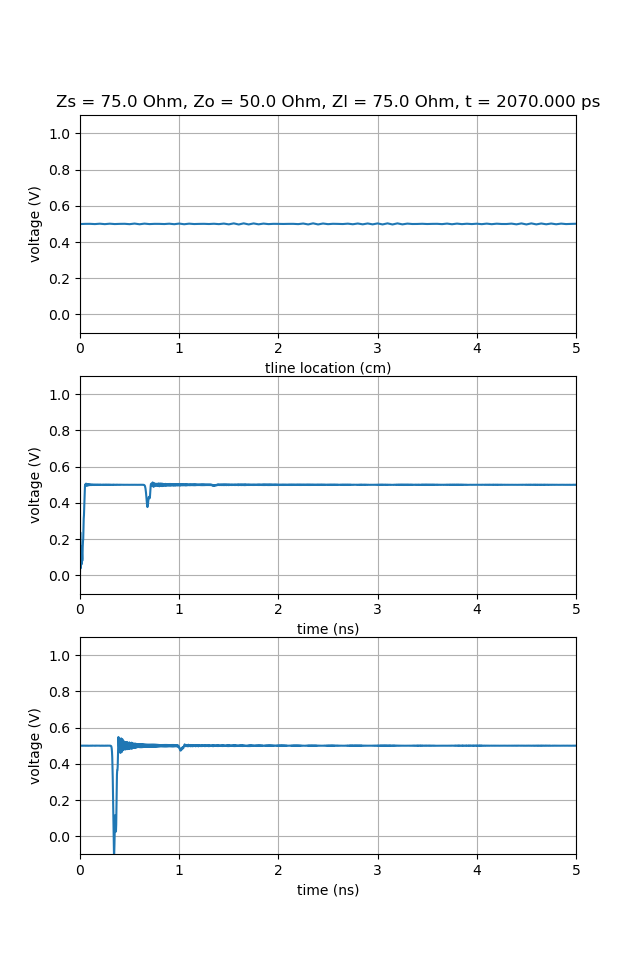

Av condition =  75.67682627644892
[[0.01       0.00333333 0.        ]
 [0.         0.02666667 0.        ]
 [0.         0.         0.02666667]]


In [4]:

t, dt = np.linspace(0., 5e-9, N, retstep=True)
x, dz = np.linspace(0., l, K, retstep=True)

# Define the source voltage.
def unitstep(t, t0):
    return (t >= t0) * 1.0

def unitramp(t, t0):
    return unitstep(t,t0) * (t-t0)

tstart = 25e-12 
tstop = 10000e-12 
tramp = 25e-12 
vs = (unitramp(t, tstart) - unitramp(t,tstart+tramp) - unitramp(t,tstop) + unitramp(t,tstop+tramp))/tramp

# Initialize the matrices.
Av = np.zeros((K+2,K+2)) # x vv next
Bv = np.zeros((K+2,K+2)) # x vv previous
Cv = -np.eye(K+2,K-1) + np.eye(K+2,K-1,-1)  # x iv previous
Dv = np.zeros(K+2) # vs

# Fill the matrices.  (These are static in this form.)
v_coeff = dz / (c * Zo * dt)
v_coeff_by_8 = v_coeff / 8.
v_coeff_by_8_times_3 = 3. * v_coeff_by_8

Av[0][0] = v_coeff_by_8_times_3
Av[0][1] = v_coeff_by_8
Av[0][K] = -0.5 # Source current term

Bv[0][0] = v_coeff_by_8_times_3
Bv[0][1] = v_coeff_by_8
Bv[0][K] = 0.5 # Source current term

for k in range(1,K-1):
    Av[k][k] = v_coeff
    Bv[k][k] = v_coeff

Av[K-1][K-2] = v_coeff_by_8
Av[K-1][K-1] = v_coeff_by_8_times_3
Av[K-1][K+1] = 0.5 # Load current term

Bv[K-1][K-2] = v_coeff_by_8
Bv[K-1][K-1] = v_coeff_by_8_times_3
Bv[K-1][K+1] = -0.5 # Load current term

# source equation fill
Av[K][0] = 1./Zs 
Av[K][K] = 1.
Dv[K] = 1./Zs

# load equation fill
Av[K+1][K-1] = 1./Zl 
Av[K+1][K+1] = -1.

############################################################
############################################################
############################################################
# Current update equations
i_coeff = c*dt/(Zo*dz)
Ai = np.eye(K-1,K-1) # not used, just here for illustrative purposes
Bi = np.eye(K-1,K-1) # not used
Ci = np.eye(K-1,K+2) - np.eye(K-1,K+2,1) # times v^{n+1/2}

############################################################
############################################################
############################################################

# Time stepping
vv = np.zeros(K+2) # voltage vector + auxiliary load current variables
iv = np.zeros(K-1) # current vector

N = len(t)
nn = 0
vrecord = []
irecord = []

xfcn = lambda x_ : x_*1e9

fig = plt.figure(figsize=(6.4,9.6))
a = fig.add_subplot(3,1,1)
asource = fig.add_subplot(3,1,2, sharey=a)
aload = fig.add_subplot(3,1,3, sharex=asource, sharey=a)
#p = PlotObject()
#a = p.axes
L, = a.plot(x, vv[:-2]); a.grid(True)
a.set_ylim(-0.1, 1.1)
a.set_xlim(0, l)
a.set_xlabel('tline location (cm)')
a.set_ylabel('voltage (V)')
a.grid(True)

vsource = 0*t
Lsource, = asource.plot(xfcn(t), vsource)
#asource.set_ylim(-1.1, 1.1)
asource.set_xlim(xfcn(t[0]), xfcn(t[-1]))
asource.set_xlabel('time (ns)')
asource.set_ylabel('voltage (V)')
asource.grid(True)

vload = 0*t
Lload, = aload.plot(xfcn(t), vload)
#aload.set_ylim(-1.1, 1.1)
aload.set_xlim(xfcn(t[0]), xfcn(t[-1]))
aload.set_xlabel('time (ns)')
aload.set_ylabel('voltage (V)')
aload.grid(True)

print ("Av condition = ", np.linalg.cond(Av))
print (Av[0:3][:,0:3])

def draw_plot(n):   
    global vv
    global iv
    # update voltage n+1/2
    y0 = np.dot(Bv, vv)
    y1 = np.dot(Cv, iv)
    y2 = Dv*vs[n]
    y = y0 + y1 + y2    
    vv = np.linalg.solve(Av, y)
    #vrecord.append(vv)
    
    # update current n+1
    iv = iv + i_coeff*np.dot(Ci,vv)
    #irecord.append(iv)
    
    # update the plot
    L.set_ydata(vv[:-2])

    vsource[n] = vv[0]
    Lsource.set_ydata(vsource)

    vload[n] = vv[-3]
    Lload.set_ydata(vload)

    #a.set_ylim(np.min(vv[:-2]),np.max(vv[:-2]))
    a.set_title('Zs = %.1f Ohm, Zo = %.1f Ohm, Zl = %.1f Ohm, t = %.3f ps' % (Zs, Zo, Zl, (t[n] * 1e12)))
    return [L, Lsource, Lload]

In [5]:
anim = animation.FuncAnimation(fig, draw_plot, frames=len(t), interval=20, blit=True)
FFwriter = animation.FFMpegWriter(fps=20)
anim.save('fdtd_pulse_3sub_l%dcm_Zs%d_Zo%d_Zl%d.mp4' % (l, Zs, Zo, Zl), writer=FFwriter)

In [ ]:
#HTML(anim.to_html5_video(embed_limit=1000)) # This embedding doesn't work in vscode, but the save above does.

# Let's Try it with a Capacitive Load

In [ ]:

t, dt = np.linspace(0., 5e-9, N, retstep=True)
x, dz = np.linspace(0., l, K, retstep=True)

# Define the source voltage.
def unitstep(t, t0):
    return (t >= t0) * 1.0

def unitramp(t, t0):
    return unitstep(t,t0) * (t-t0)

tstart = 25e-12 
tstop = 10000e-12 
tramp = 25e-12 
vs = (unitramp(t, tstart) - unitramp(t,tstart+tramp) - unitramp(t,tstop) + unitramp(t,tstop+tramp))/tramp

# Initialize the matrices.
Av = np.zeros((K+2,K+2)) # x vv next
Bv = np.zeros((K+2,K+2)) # x vv previous
Cv = -np.eye(K+2,K-1) + np.eye(K+2,K-1,-1)  # x iv previous
Dv = np.zeros(K+2) # vs

# Fill the matrices.  (These are static in this form.)
v_coeff = dz / (c * Zo * dt)
v_coeff_by_8 = v_coeff / 8.
v_coeff_by_8_times_3 = 3. * v_coeff_by_8

Av[0][0] = v_coeff_by_8_times_3
Av[0][1] = v_coeff_by_8
Av[0][K] = -0.5 # Source current term i_s[n+1/2]

Bv[0][0] = v_coeff_by_8_times_3
Bv[0][1] = v_coeff_by_8
Bv[0][K] = 0.5 # Source current term i_s[n-1/2]

for k in range(1,K-1):
    Av[k][k] = v_coeff
    Bv[k][k] = v_coeff

Av[K-1][K-2] = v_coeff_by_8
Av[K-1][K-1] = v_coeff_by_8_times_3
Av[K-1][K+1] = 0.5 # Load current term i_l[n+1/2]

Bv[K-1][K-2] = v_coeff_by_8
Bv[K-1][K-1] = v_coeff_by_8_times_3
Bv[K-1][K+1] = -0.5 # Load current term i_l[n-1/2]

# source equation fill
Av[K][0] = 1./Zs 
Av[K][K] = 1.
Dv[K] = 1./Zs

# load equation fill
# Av[K+1][K-1] = 1./Zl 
# Av[K+1][K+1] = -1.
Av[K+1][K-1] = -Cload/dt
Av[K+1][K+1] = 0.5
Bv[K+1][K-1] = -Cload/dt
Bv[K+1][K+1] = -0.5

############################################################
############################################################
############################################################
# Current update equations
i_coeff = c*dt/(Zo*dz)
Ai = np.eye(K-1,K-1) # not used, just here for illustrative purposes
Bi = np.eye(K-1,K-1) # not used
Ci = np.eye(K-1,K+2) - np.eye(K-1,K+2,1) # times v^{n+1/2}

############################################################
############################################################
############################################################

# Time stepping
vv = np.zeros(K+2) # voltage vector + auxiliary source/load current variables
iv = np.zeros(K-1) # current vector

N = len(t)
nn = 0
vrecord = []
irecord = []

xfcn = lambda x_ : x_*1e9

fig = plt.figure(figsize=(6.4,9.6))
a = fig.add_subplot(3,1,1)
asource = fig.add_subplot(3,1,2, sharey=a)
aload = fig.add_subplot(3,1,3, sharex=asource, sharey=a)
#p = PlotObject()
#a = p.axes
L, = a.plot(x, vv[:-2]); a.grid(True)
a.set_ylim(-0.1, 1.1)
a.set_xlim(0, l)
a.set_xlabel('tline location (cm)')
a.set_ylabel('voltage (V)')
a.grid(True)

vsource = 0*t
Lsource, = asource.plot(xfcn(t), vsource)
#asource.set_ylim(-1.1, 1.1)
asource.set_xlim(xfcn(t[0]), xfcn(t[-1]))
asource.set_xlabel('time (ns)')
asource.set_ylabel('voltage (V)')
asource.grid(True)

vload = 0*t
Lload, = aload.plot(xfcn(t), vload)
#aload.set_ylim(-1.1, 1.1)
aload.set_xlim(xfcn(t[0]), xfcn(t[-1]))
aload.set_xlabel('time (ns)')
aload.set_ylabel('voltage (V)')
aload.grid(True)

print ("Av condition = ", np.linalg.cond(Av))
print (Av[0:3][:,0:3])

def draw_plot(n):   
    global vv
    global iv
    # update voltage n+1/2
    y0 = np.dot(Bv, vv)
    y1 = np.dot(Cv, iv)
    y2 = Dv*vs[n]
    y = y0 + y1 + y2    
    vv = np.linalg.solve(Av, y)
    #vrecord.append(vv)
    
    # update current n+1
    iv = iv + i_coeff*np.dot(Ci,vv)
    #irecord.append(iv)
    
    # update the plot
    L.set_ydata(vv[:-2])
    #a.set_ylim(np.min(vv[:-2]),np.max(vv[:-2]))

    vsource[n] = vv[0]
    Lsource.set_ydata(vsource)

    vload[n] = vv[-3]
    Lload.set_ydata(vload)

    a.set_title('Zs = %.1f Ohm, Zo = %.1f Ohm, Cl = %.1f pF, t = %.3f ps' % (Zs, Zo, (Cload*1e12), (t[n] * 1e12)))
    return [L, Lsource, Lload]

<IPython.core.display.Javascript object>

Av condition =  84.02542249533732
[[0.01       0.00333333 0.        ]
 [0.         0.02666667 0.        ]
 [0.         0.         0.02666667]]


In [ ]:
anim = animation.FuncAnimation(fig, draw_plot, frames=len(t), interval=20, blit=True)
FFwriter = animation.FFMpegWriter(fps=20)
anim.save('fdtd_pulse_3sub_l%dcm_Zs%d_Zo%d_Cl%dpF.mp4' % (l, Zs, Zo, Cload*1e12), writer=FFwriter)

# Sinusoidal

In [ ]:

t, dt = np.linspace(0., 5e-9, N, retstep=True)
x, dz = np.linspace(0., l, K, retstep=True)

# Define the source voltage.
f = 8e9
f_ghz = f/1e9
vs = np.sin(2*np.pi*f*t)

# Initialize the matrices.
Av = np.zeros((K+2,K+2)) # x vv next
Bv = np.zeros((K+2,K+2)) # x vv previous
Cv = -np.eye(K+2,K-1) + np.eye(K+2,K-1,-1)  # x iv previous
Dv = np.zeros(K+2) # vs

# Fill the matrices.  (These are static in this form.)
v_coeff = dz / (c * Zo * dt)
v_coeff_by_8 = v_coeff / 8.
v_coeff_by_8_times_3 = 3. * v_coeff_by_8

Av[0][0] = v_coeff_by_8_times_3
Av[0][1] = v_coeff_by_8
Av[0][K] = -0.5

Bv[0][0] = v_coeff_by_8_times_3
Bv[0][1] = v_coeff_by_8
Bv[0][K] = 0.5

for k in range(1,K-1):
    Av[k][k] = v_coeff
    Bv[k][k] = v_coeff

Av[K-1][K-2] = v_coeff_by_8
Av[K-1][K-1] = v_coeff_by_8_times_3
Av[K-1][K+1] = 0.5

Bv[K-1][K-2] = v_coeff_by_8
Bv[K-1][K-1] = v_coeff_by_8_times_3
Bv[K-1][K+1] = -0.5

# source equation fill
Av[K][0] = 1./Zs 
Av[K][K] = 1.
Dv[K] = 1./Zs

# load equation fill
Av[K+1][K-1] = 1./Zl 
Av[K+1][K+1] = -1.

############################################################
############################################################
############################################################
# Current update equations
i_coeff = c*dt/(Zo*dz)
Ai = np.eye(K-1,K-1) # not used, just here for illustrative purposes
Bi = np.eye(K-1,K-1) # not used
Ci = np.eye(K-1,K+2) - np.eye(K-1,K+2,1) # times v^{n+1/2}

############################################################
############################################################
############################################################

# Time stepping
vv = np.zeros(K+2) # voltage vector + auxiliary load current variables
iv = np.zeros(K-1) # current vector

N = len(t)
nn = 0
vrecord = []
irecord = []

xfcn = lambda x_ : x_*1e9

fig = plt.figure(figsize=(6.4,9.6))
a = fig.add_subplot(3,1,1)
asource = fig.add_subplot(3,1,2, sharey=a)
aload = fig.add_subplot(3,1,3, sharex=asource, sharey=a)
#p = PlotObject()
#a = p.axes
L, = a.plot(x, vv[:-2]); a.grid(True)
a.set_ylim(-1.1, 1.1)
a.set_xlim(0, l)
a.set_xlabel('tline location (cm)')
a.set_ylabel('voltage (V)')
a.grid(True)

vsource = 0*t
Lsource, = asource.plot(xfcn(t), vsource)
#asource.set_ylim(-1.1, 1.1)
asource.set_xlim(xfcn(t[0]), xfcn(t[-1]))
asource.set_xlabel('time (ns)')
asource.set_ylabel('voltage (V)')
asource.grid(True)

vload = 0*t
Lload, = aload.plot(xfcn(t), vload)
#aload.set_ylim(-1.1, 1.1)
aload.set_xlim(xfcn(t[0]), xfcn(t[-1]))
aload.set_xlabel('time (ns)')
aload.set_ylabel('voltage (V)')
aload.grid(True)

print ("Av condition = ", np.linalg.cond(Av))
print (Av[0:3][:,0:3])

def draw_plot(n):   
    global vv
    global iv
    # update voltage n+1/2
    y0 = np.dot(Bv, vv)
    y1 = np.dot(Cv, iv)
    y2 = Dv*vs[n]
    y = y0 + y1 + y2    
    vv = np.linalg.solve(Av, y)
    #vrecord.append(vv)
    
    # update current n+1
    iv = iv + i_coeff*np.dot(Ci,vv)
    #irecord.append(iv)
    
    # update the plot
    L.set_ydata(vv[:-2])
    #a.set_ylim(np.min(vv[:-2]),np.max(vv[:-2]))

    vsource[n] = vv[0]
    Lsource.set_ydata(vsource)

    vload[n] = vv[-3]
    Lload.set_ydata(vload)

    a.set_title('f = %.2f GHz, Zs = %.1f Ohm, Zo = %.1f Ohm, Zl = %.1f Ohm, t = %.3f ps' % (f_ghz, Zs, Zo, Zl, (t[n] * 1e12)), size=10)
    return [L,]

<IPython.core.display.Javascript object>

Av condition =  84.05770016902716
[[0.01       0.00333333 0.        ]
 [0.         0.02666667 0.        ]
 [0.         0.         0.02666667]]


In [ ]:
anim = animation.FuncAnimation(fig, draw_plot, frames=len(t), interval=20, blit=True)
FFwriter = animation.FFMpegWriter(fps=20)
anim.save('fdtd_sinusoidal_3sub_f%dghz_l%dcm_Zs%d_Zo%d_Zl%d.mp4' % (f_ghz, l, Zs, Zo, Zl), writer=FFwriter)

## Capacitive Load Version

In [ ]:

t, dt = np.linspace(0., 5e-9, N, retstep=True)
x, dz = np.linspace(0., l, K, retstep=True)

# Define the source voltage.
f = 1e9
f_ghz = f/1e9
vs = np.sin(2*np.pi*f*t)

# Initialize the matrices.
Av = np.zeros((K+2,K+2)) # x vv next
Bv = np.zeros((K+2,K+2)) # x vv previous
Cv = -np.eye(K+2,K-1) + np.eye(K+2,K-1,-1)  # x iv previous
Dv = np.zeros(K+2) # vs

# Fill the matrices.  (These are static in this form.)
v_coeff = dz / (c * Zo * dt)
v_coeff_by_8 = v_coeff / 8.
v_coeff_by_8_times_3 = 3. * v_coeff_by_8

Av[0][0] = v_coeff_by_8_times_3
Av[0][1] = v_coeff_by_8
Av[0][K] = -0.5 # Source current term i_s[n+1/2]

Bv[0][0] = v_coeff_by_8_times_3
Bv[0][1] = v_coeff_by_8
Bv[0][K] = 0.5 # Source current term i_s[n-1/2]

for k in range(1,K-1):
    Av[k][k] = v_coeff
    Bv[k][k] = v_coeff

Av[K-1][K-2] = v_coeff_by_8
Av[K-1][K-1] = v_coeff_by_8_times_3
Av[K-1][K+1] = 0.5 # Load current term i_l[n+1/2]

Bv[K-1][K-2] = v_coeff_by_8
Bv[K-1][K-1] = v_coeff_by_8_times_3
Bv[K-1][K+1] = -0.5 # Load current term i_l[n-1/2]

# source equation fill
Av[K][0] = 1./Zs 
Av[K][K] = 1.
Dv[K] = 1./Zs

# load equation fill
# Av[K+1][K-1] = 1./Zl 
# Av[K+1][K+1] = -1.
Av[K+1][K-1] = -Cload/dt
Av[K+1][K+1] = 0.5
Bv[K+1][K-1] = -Cload/dt
Bv[K+1][K+1] = -0.5

############################################################
############################################################
############################################################
# Current update equations
i_coeff = c*dt/(Zo*dz)
Ai = np.eye(K-1,K-1) # not used, just here for illustrative purposes
Bi = np.eye(K-1,K-1) # not used
Ci = np.eye(K-1,K+2) - np.eye(K-1,K+2,1) # times v^{n+1/2}

############################################################
############################################################
############################################################

# Time stepping
vv = np.zeros(K+2) # voltage vector + auxiliary source/load current variables
iv = np.zeros(K-1) # current vector

N = len(t)
nn = 0
vrecord = []
irecord = []

xfcn = lambda x_ : x_*1e9

fig = plt.figure(figsize=(6.4,9.6))
a = fig.add_subplot(3,1,1)
asource = fig.add_subplot(3,1,2, sharey=a)
aload = fig.add_subplot(3,1,3, sharex=asource, sharey=a)
#p = PlotObject()
#a = p.axes
L, = a.plot(x, vv[:-2]); a.grid(True)
a.set_ylim(-1.1, 1.1)
a.set_xlim(0, l)
a.set_xlabel('tline location (cm)')
a.set_ylabel('voltage (V)')
a.grid(True)

vsource = 0*t
Lsource, = asource.plot(xfcn(t), vsource)
#asource.set_ylim(-1.1, 1.1)
asource.set_xlim(xfcn(t[0]), xfcn(t[-1]))
asource.set_xlabel('time (ns)')
asource.set_ylabel('voltage (V)')
asource.grid(True)

vload = 0*t
Lload, = aload.plot(xfcn(t), vload)
#aload.set_ylim(-1.1, 1.1)
aload.set_xlim(xfcn(t[0]), xfcn(t[-1]))
aload.set_xlabel('time (ns)')
aload.set_ylabel('voltage (V)')
aload.grid(True)

print ("Av condition = ", np.linalg.cond(Av))
print (Av[0:3][:,0:3])

def draw_plot(n):   
    global vv
    global iv
    # update voltage n+1/2
    y0 = np.dot(Bv, vv)
    y1 = np.dot(Cv, iv)
    y2 = Dv*vs[n]
    y = y0 + y1 + y2    
    vv = np.linalg.solve(Av, y)
    #vrecord.append(vv)
    
    # update current n+1
    iv = iv + i_coeff*np.dot(Ci,vv)
    #irecord.append(iv)
    
    # update the plot
    L.set_ydata(vv[:-2])
    #a.set_ylim(np.min(vv[:-2]),np.max(vv[:-2]))

    vsource[n] = vv[0]
    Lsource.set_ydata(vsource)

    vload[n] = vv[-3]
    Lload.set_ydata(vload)

    a.set_title('Zs = %.1f Ohm, Zo = %.1f Ohm, Cl = %.1f pF, t = %.3f ps' % (Zs, Zo, (Cload*1e12), (t[n] * 1e12)))
    return [L, Lsource, Lload]

<IPython.core.display.Javascript object>

Av condition =  302.98096347578036
[[0.01       0.00333333 0.        ]
 [0.         0.02666667 0.        ]
 [0.         0.         0.02666667]]


In [ ]:
anim = animation.FuncAnimation(fig, draw_plot, frames=len(t), interval=20, blit=True)
FFwriter = animation.FFMpegWriter(fps=20)
anim.save('fdtd_sinusoidal_3sub_f%dghz_l%dcm_Zs%d_Zo%d_Cl%dpF.mp4' % (f_ghz, l, Zs, Zo, (Cload*1e12)), writer=FFwriter)